In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as stats
import scipy.io as io

plt.rc("font", family=["Helvetica", "Arial"]) #skifter skrifttype
plt.rc("axes", labelsize=18)   #skriftstørrelse af `xlabel` og `ylabel`
plt.rc("xtick", labelsize=16, direction="out")  #skriftstørrelse af ticks og viser ticks øverst
plt.rc("ytick", labelsize=16, direction="out")
plt.rc("axes", titlesize=22)
plt.rc("legend", fontsize=16)

In [2]:
entries_list_pT = os.listdir(r"C:\Users\Karsten\eksperimental\Experimentel-Physics-2\Tredje labdag\Luft til glas\p\transmitteret")
entries_list_pR = os.listdir(r"C:\Users\Karsten\eksperimental\Experimentel-Physics-2\Tredje labdag\Luft til glas\p\reflekteret")

d = io.loadmat(r"C:\Users\Karsten\eksperimental\Experimentel-Physics-2\Tredje labdag\baggrund måling.mat")
d_offset = d.get("A")
d_offset = np.reshape(d_offset, (len(d_offset)))

# Konstant funktion
def func(x, a):
    return a

# Fit af kontakt funktion til gennemsnit
t = np.linspace(0, 50, len(d_offset))
mean_Voff, pcovoff = curve_fit(func, t, d_offset, absolute_sigma=True)
usOff = np.sqrt(np.diag(pcovoff))

# Henter data fra 90 grader 
d = io.loadmat(r"C:\Users\Karsten\eksperimental\Experimentel-Physics-2\Tredje labdag\Luft til glas\p - 90 grader med krystal.mat")
d90 = d.get("A")
d90 = np.reshape(d90, (len(d90)))

# Fit af kontakt funktion til 90 grader
t = np.linspace(0, 50, len(d90))
mean_V90, pcov90 = curve_fit(func, t, d90, absolute_sigma=True)
us90 = np.sqrt(np.diag(pcov90))
mean_V90 = mean_V90 - mean_Voff


In [3]:
# Funktion som henter intensiteterne 

def get_ts_Vs(t, entries):
    if t == "T":
        rempart = "t("
        file_dest = "transmitteret"
    else:
        rempart = "r("
        file_dest = "reflekteret"
        
    ts = np.zeros((len(entries), 2))
    Vs = np.zeros((len(entries),2))
    for i, file in enumerate(entries):
        name = file.replace(rempart, "")
        name = name.replace(".mat", "")
        name = name.replace(")", "")
        indx = name.find(",")
        ts12 = float(name[0:indx])*np.pi/180, float(name[indx + 1:len(name)])*np.pi/180
        ts[i] = ts12
        
    for i, file in enumerate(entries):
        dat = io.loadmat(f"C:/Users/Karsten/eksperimental/Experimentel-Physics-2/Tredje labdag/Luft til glas/p/{file_dest}/{file}")
        V = dat.get("A")
        V = np.reshape(V, (len(V)))
        xs = np.linspace(0, 50, len(V))
        fitted, pcov = curve_fit(func, xs, V, absolute_sigma=True)
        perr1 = np.sqrt(np.diag(pcov))
        Vs[i][0] = fitted - mean_Voff
        Vs[i][1] = perr1
        
    return Vs, ts


In [4]:
# Henter thetaer og intensiteter

mean_VsT, ts_trans = get_ts_Vs("T", entries_list_pT)
mean_VsR, ts_ref = get_ts_Vs("R", entries_list_pR)


In [5]:
# Finder Rp og Tp

Ts = mean_VsT/mean_V90
Rs = mean_VsR/mean_V90

uncer_Ts = []
uncer_Rs = []

for i in range(len(Ts)) :
    uncer_Ts.append(Ts[i][1])
for i in range(len(Rs)) : 
    uncer_Rs.append(Rs[i][1])


In [6]:
uncer = 0.5 # DEGREES
sigma_radian = np.pi/180 * uncer
print(sigma_radian)


0.008726646259971648


[0.17453293 0.26179939 0.34906585 0.43633231 0.52359878 0.61086524
 0.6981317  0.78539816 0.82030475 0.85521133 0.08726646 0.89011792
 0.9250245  0.95993109 0.99483767 1.02974426 1.06465084 1.09955743
 1.13446401 1.22173048]


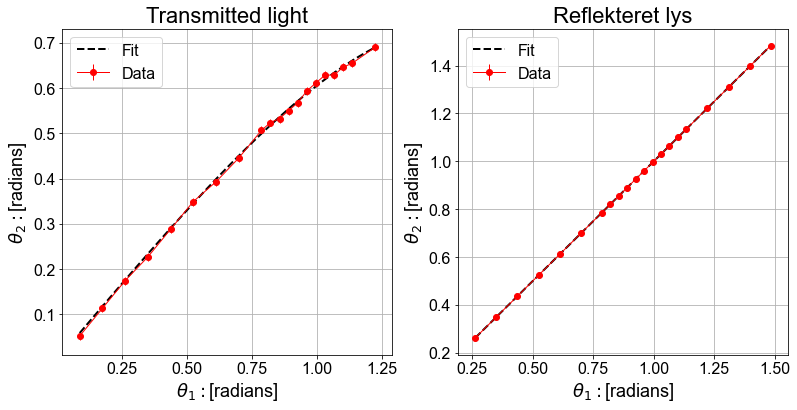

In [7]:
fig, axs = plt.subplots(1,2, figsize=(13,6))
axs[1].set_title("Reflekteret lys")
axs[0].set_title("Transmitted light")

def snell(theta, n):
    theta_ag = np.arcsin(n*np.sin(theta))
    return theta_ag

theta1T = np.zeros(len(ts_trans))
theta2T = np.zeros(len(ts_trans))

theta1R = np.zeros(len(ts_ref))
theta2R = np.zeros(len(ts_ref))

i = 0
for t1, t2 in ts_trans:
    theta1T[i] = t1
    theta2T[i] = t1 - t2
    i = i + 1
    
i = 0
for t1, t2 in ts_ref:
    theta1R[i] = t1
    theta2R[i] = t1
    i = i + 1
    
theta1T1 = theta1T[0:len(theta1T)-3]
theta2T1 = theta2T[0:len(theta2T)-3]

print(theta1T1)
axs[0].errorbar(np.sort(theta1T1), np.sort(theta2T1), xerr=sigma_radian, yerr=sigma_radian, lw=1, label="Data", c='r', fmt='o-')
axs[1].errorbar(np.sort(theta1R), np.sort(theta2R), xerr=sigma_radian, yerr=sigma_radian, lw=1, label="Data", c='r', fmt='o-')

nT, pcovT = curve_fit(snell, theta1T1, theta2T1, absolute_sigma=True, maxfev=5000)
nR, pcovR = curve_fit(snell, theta1R, theta2R, absolute_sigma=True)

theta_T = np.linspace(min(theta1T1), max(theta1T1))
theta_R = np.linspace(min(theta1R), max(theta1R))

axs[0].plot(theta_T, snell(theta_T, nT), c='k', ls="--", label="Fit", lw=2)
axs[1].plot(theta_R, snell(theta_R, nR), c='k', ls="--", label="Fit", lw=2)

for ax in axs:
    ax.grid()
    ax.set_xlabel(r"$\theta_1: $[radians]")
    ax.set_ylabel(r"$\theta_2: $[radians]")
    ax.legend()


In [8]:
print(nR, nT)

nT_true = 1/nT
print(nT_true)

[1.] [0.67671266]
[1.47773207]


<ipython-input-26-2e61ad31cb04>:13: RuntimeWarning: invalid value encountered in arcsin
  theta_2 = np.arcsin(1/n_komb*np.sin(theta_1))


Text(0, 0.5, '$R_p$')

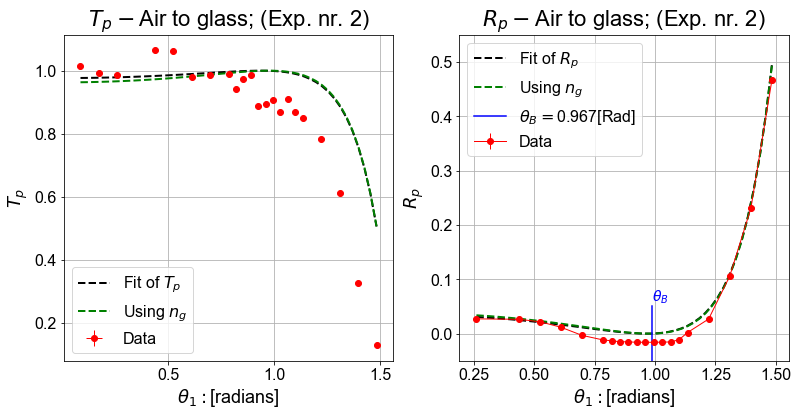

In [26]:
fig, axs = plt.subplots(1,2, figsize=(13,6))
axs[1].set_title(r"$R_p-$Air to glass; (Exp. nr. 2)")
axs[0].set_title(r"$T_p-$Air to glass; (Exp. nr. 2)")
axs[1].set_ylim([-0.05, 0.55])


def Rkoef(theta_1, n_komb): #Gælder kun for P polariseret lys
    theta_2 = np.arcsin(1/n_komb*np.sin(theta_1)) 
    R_p = (np.tan(theta_1-theta_2)**2)/(np.tan(theta_1+theta_2)**2)
    return R_p

def Tkoef(theta_1, n_komb): #Gælder kun for P polariseret lys
    theta_2 = np.arcsin(1/n_komb*np.sin(theta_1))
    T_p = (np.sin(2*theta_1)*np.sin(2*theta_2))/(np.sin(theta_1+theta_2)**2*np.cos(theta_1-theta_2)**2)
    return T_p

# Intensiteter 
Tl_uc = []
Rl_uc = []
Tl = [] #Fjerner vinkler og punkter, hvor T,R ikke ligger mellem intervallet [0,1]
Rl = []

# Vinkler
theta_newT = []
theta_newR = []
uncer_Ts_new = []
uncer_Rs_new = []

for i, a in enumerate(Ts):
    if a[0] > 0.03:
        Tl.append(a[0])
        theta_newT.append(theta1T[i])
        Tl_uc.append(0.00207041)

for i, a in enumerate(Rs):
    if a[0] < 1:
        Rl.append(a[0])
        theta_newR.append(theta1R[i])
        Rl_uc.append(0.00207041)
theta_B_m = np.arctan(1.5133902494504998/1)
theta_B_l = np.arctan(1.4345056407142855/1)
theta_B_u = np.arctan(1.6125600985714286/1)



theta_T = np.linspace(min(theta_newT), max(theta_newT))
theta_R = np.linspace(min(theta_newR), max(theta_newR))

nTT, pcovnT = curve_fit(Tkoef, theta_newT, Tl, p0=[1.4])
nRR, pcovnR = curve_fit(Rkoef, theta_newR, Rl, p0=[1.4])

theta_B_R = np.arctan(nRR/1)


axs[0].errorbar(theta_newT, Tl, xerr=sigma_radian, yerr=Tl_uc, lw=1, label="Data", c='r', fmt='o')
axs[1].errorbar(theta_newR, Rl, xerr=sigma_radian, yerr=Rl_uc, lw=1, label="Data", c='r', fmt='o-')
axs[0].plot(theta_T, Tkoef(theta_T, nTT), ls="--", c="k", lw=2, label=r"Fit of $T_p$")
axs[1].plot(theta_R, Rkoef(theta_R, nRR), ls="--", c="k", lw=2, label=r"Fit of $R_p$")

axs[0].plot(theta_T, Tkoef(theta_T, 1/nT), ls="--", c="g", lw=2, label=r"Using $n_g$")
axs[1].plot(theta_R, Rkoef(theta_R, 1/nT), ls="--", c="g", lw=2, label=r"Using $n_g$")

axs[1].plot([theta_B_m, theta_B_m], [-0.2, 0.05], '-' ,c='b', label=r"$\theta_B = $"f"{round(theta_B_R[0],3)}[Rad]")
axs[1].annotate(r"$\theta_B$", xy=(theta_B_R, -0.05),  xytext=(theta_B_R +0.02, 0.06),  fontsize=14, c="b")
for ax in axs:
    ax.grid()
    ax.legend()
    ax.set_xlabel(r"$\theta_1: $[radians]")
axs[0].set_ylabel(r"$T_p$")
axs[1].set_ylabel(r"$R_p$")



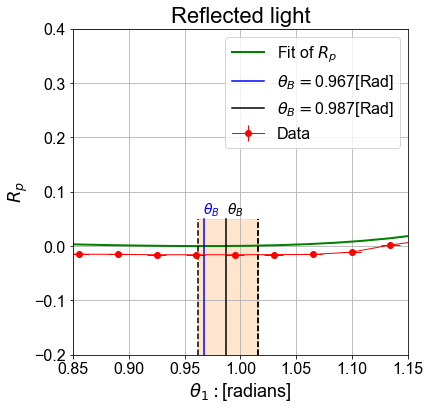

In [22]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_title("Reflected light")
ax.set_ylim([-0.05, 0.55])

ax.set_xlim([0.85, 1.15])
ax.set_ylim([-0.2, 0.4])
ax.set_xlabel(r"$\theta_1 :$[radians]")
ax.set_ylabel(r"$R_p$")


ax.plot(theta_R, Rkoef(theta_R, nRR), ls="-", c="g", lw=2, label=r"Fit of $R_p$")
ax.plot([theta_B_l, theta_B_l], [-0.2, 0.05], '--' ,c='k')
ax.plot([theta_B_u, theta_B_u], [-0.2, 0.05], '--' ,c='k')
ax.plot([theta_B_u, theta_B_u], [-0.2, 0.05], '--' ,c='k')
ax.plot([theta_B_R, theta_B_R], [-0.2, 0.05], "-" ,c='b', label=r"$\theta_B = $"f"{round(theta_B_R[0],3)}[Rad]")
ax.plot([theta_B_m, theta_B_m], [-0.2, 0.05], '-' ,c='k', label=r"$\theta_B = $"f"{round(theta_B_m,3)}[Rad]")
#ax.plot(theta_newR, Rl,'o-', c='r', label="Data")
ax.errorbar(theta_newR, Rl, xerr=sigma_radian, yerr=Rl_uc, lw=1, label="Data", c='r', fmt='o-')
ax.fill_between([theta_B_l,theta_B_u], 0.05, -0.2, color='C1', alpha=0.2)
ax.annotate(r"$\theta_B$", xy=(theta_B_m, -0.05),  xytext=(theta_B_m + 0.001, 0.06),  fontsize=14)
ax.annotate(r"$\theta_B$", xy=(theta_B_R, -0.05),  xytext=(theta_B_R - 0.001, 0.06),  fontsize=14, c="b")
ax.grid()
ax.legend()

In [19]:
print(nTT, nRR)
#print(1/nT)
#print(np.sqrt(np.diag(pcovT)))
print(np.sqrt(np.diag(pcovnT)))
print(np.sqrt(np.diag(pcovnR)))

0.07

#print(np.arctan((0.07)/1))
#print(np.arctan((nRR + 0.07)/1))

[1.36164111] [1.45139738]
[0.68170675]
[0.07172694]


0.07

# P-værdi og Chi^2 min værdi - for snells lov fit

In [12]:
yerr = np.zeros(len(theta1T))
for i in range(len(yerr)):
    yerr[i] = 0.5*np.pi/180 #Fejlen på vores vinkler

v = len(theta1T) - 1

chmin = np.sum(((theta2T-snell(theta1T, nT))/yerr)**2)
Pkhi = round(1 - stats.chi2.cdf(chmin,v), 2) 

In [13]:
print(v - 2*np.sqrt(v), " < ", chmin, " < ", v + 2*np.sqrt(v))
print(Pkhi)

12.61916848035314  <  10.969715616605217  <  31.38083151964686
0.98


# P-værdi og Chi^2 min værdi - for T og R fit

In [27]:
yerr = np.zeros(len(Tl))
for i in range(len(yerr)):
    yerr[i] = 0.002943/np.sqrt(len(Tl)) #Fejlen på vores vinkler

v = len(Tl) - 1
print(len(Tl), len(theta_newT), len(yerr))
chmin = np.sum(((np.array([theta_newT])-Tkoef(np.array([theta_newT]), nTT))/yerr)**2)
Pkhi = round(1 - stats.chi2.cdf(chmin,v), 2) 

22 22 22


In [28]:
print(v - 2*np.sqrt(v), " < ", chmin, " < ", v + 2*np.sqrt(v))
print(Pkhi)

11.83484861008832  <  11331203.539761819  <  30.165151389911678
0.0


In [29]:
yerr = np.zeros(len(Rl))
for i in range(len(yerr)):
    yerr[i] = 0.002943/np.sqrt(len(Rl)) #Fejlen på vores vinkler

v = len(Rl) - 1

chmin = np.sum(((Rl-Rkoef(theta_newR, nRR))/yerr)**2)
Pkhi = round(1 - stats.chi2.cdf(chmin,v), 2) 

In [30]:
print(v - 2*np.sqrt(v), " < ", chmin, " < ", v + 2*np.sqrt(v))
print(Pkhi)

10.282202112918652  <  10810.198024700505  <  27.717797887081346
0.0


In [33]:
11331203*10**(-6)

11.331203